### Import everything you may need

In [147]:
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical as make_class_categorical

### Load data

In [148]:
def LoadBatch(filename):

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo)
        return dict

    dictionary = unpickle(filename)
    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')
            
    garbage = ix(dictionary,1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = dictionary['data']
    X = np.transpose(garbage) / 255.0


    return X, Y, y

### Initialize weights

In [149]:
def initialize_weights(d, K, variance, mode):


    np.random.seed(400)

    if mode =="simple xavier":
        variance = 1.0/float(d)
    elif mode == "xavier":
        variance = 2.0 / float(K+d)

    weight_matrix = np.random.normal(0,variance, (K,d))
    bias = np.random.normal(0 ,variance, (K,1))

    return weight_matrix, bias

### Softmax mode to handle overflow occasion

In [150]:

def softmax(X, theta=1.0, axis=None):

    # Softmax over numpy rows and columns, taking care for overflow cases
    # Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    # Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

###                                                         ASSIGNMENT INSTRUCTION FUNCTIONS

### EvaluateClassifier

In [151]:
def EvaluateClassifier(X, W, b):

    s = np.dot(W,X) + b
    P = softmax(s)
    return P

### Compute Cost

In [163]:
def ComputeCost(X, Y, y, W, b, regularization_term, loss_mode):

    P = EvaluateClassifier(X,W,b)

    if loss_mode=="cross-entropy":

        cross_entropy_loss = 0
        for i in range(0, X.shape[1]):
            cross_entropy_loss-= np.log(np.dot(Y[:,i].T,P[:,i]))
        cross_entropy_loss/=float(X.shape[1])

        weight_sum = np.power(W,2).sum()

        return cross_entropy_loss + regularization_term*weight_sum

### Compute Accuracy

In [164]:
def ComputeAccuracy(X, y, W, b):
# slightly modified and done through the labels y!

    P = EvaluateClassifier(X,W,b)

    miss_classified_data=0
    for i in range(X.shape[1]):

        predicted_class_index = np.argmax(P[:,i])

        if (predicted_class_index!=y[i]):
            miss_classified_data+=1

    return 1 - miss_classified_data/float(X.shape[1])

### Compute gradients

In [165]:
def ComputeGradients(X, Y, y, P, W, b, regularization_term, mode):

    gradW = np.zeros((W.shape[0],W.shape[1]))
    gradb = np.zeros((W.shape[0], 1))

    # ---------------CROSS ENTROPY LOSS---------------

    for i in range(X.shape[1]):

        g = -(Y[:,i] - P[:,i]).T
        gradb += g.T.reshape(g.shape[0], 1)
        gradW += np.dot(g.T.reshape(g.shape[0], 1), X[:, i].T.reshape(1, X.shape[0]))

    # normalize
    gradW/=X.shape[1]
    gradW+= 2*regularization_term*W
    gradb/=X.shape[1]

    return gradW, gradb

### Mini Batch GD

In [166]:
def MiniBatchGD( X, Y, validation_X, validation_Y, y, y_validation, GDparams, W, b, regularization_term,
                loss_mode, with_early_stopping, with_patience, patience=10, with_factor_decaying=False):

    number_of_mini_batches = GDparams[0]
    if with_factor_decaying:
        eta= 0.1
    else:
        eta = GDparams[1]
    epoches=GDparams[2]

    cost=[]
    val_cost=[]

    if loss_mode=="cross-entropy":

        early_stopping = 10e8

        # uncomment for patience in early stopping
        early_stopping_cnt=0

        save_W = np.copy(W)
        save_b= np.copy(b)

        temp_W = np.copy(W)
        temp_b = np.copy(b)

        for epoch in range(epoches):

            for batch in range(1,int(X.shape[1]/number_of_mini_batches)):

                start = (batch-1)*number_of_mini_batches+1
                end = batch*number_of_mini_batches+1

                P = EvaluateClassifier(X[:, start:end], W, b )

                gradW, gradb = ComputeGradients(X=X[:, start:end], Y=Y[:, start:end],y=y[start:end], P=P, W=W, b=b, regularization_term=regularization_term, mode="Cross-entropy")

                # Compute similarity between analytic and numerical computation
                # gradW_num, gradb_num = ComputeGradsNumSlow(X=X[:, start:end], Y=Y[:, start:end], y=y, W=W, b=b, regularization_term=regularization_term)
                # check_similarity(gradb, gradW, gradb_num, gradW_num)

                temp_W = np.copy(W)
                temp_b = np.copy(b)

                W-=eta*gradW
                b-=eta*gradb

            epoch_cost = ComputeCost(X=X, Y=Y, y=y, W=W, b=b, regularization_term=regularization_term, loss_mode=loss_mode)
            val_epoch_cost = ComputeCost(X=validation_X, Y=validation_Y,y=y_validation, W=W, b=b, regularization_term=regularization_term, loss_mode=loss_mode)

            # ---------EARLY STOPPING----------
            if with_early_stopping:
                if with_patience:
                    if early_stopping - val_epoch_cost > 1e-6:
                        early_stopping_cnt= 0
                        early_stopping= val_epoch_cost
                    else:
                        if early_stopping_cnt == patience:
                            print("Early stopping after "+str(epoch)+" epochs")
                            return save_W, save_b, cost, validation_cost
                        else:
                            if early_stopping_cnt == 0:
                                save_W= temp_W
                                save_b= temp_b
                            early_stopping_cnt+=1
                else:
                    if early_stopping - val_epoch_cost > 1e-6:
                        early_stopping= val_epoch_cost
                    else:
                        print("Early stopping after " + str(epoch) + " epochs")
                        return temp_W, temp_b, cost, val_cost

            cost.append(epoch_cost)
            val_cost.append(val_epoch_cost)
            
            if with_factor_decaying:
                eta*=0.9

        return W, b, cost, val_cost

## Visualizing function

In [177]:
def visualize_costs(cost, val_cost, regularization_term, eta, vis, name=None):
    if vis:
        plt.title('Cost function loss per epoch, $\lambda$=' + str(regularization_term) + ', $\eta$=' + str(eta))
        plt.plot(cost, 'g', label='Training set ')
        plt.plot(val_cost, 'r', label='Validation set')
        plt.legend(loc='upper right')
        plt.show()
        if name is not None:
            plt.savefig(name+".png")
        plt.clf()

def weights_vis(W, GDparams, regularization_term, vis, name=None):
    if vis:
        # weight visualization
        images = []
        for img in W:
            raw_img=np.rot90(img.reshape(3, 32, 32).T, -1)
            image = ((raw_img-np.min(raw_img))/(np.max(raw_img)-np.min(raw_img)))
            images.append(image)
        fig1 = plt.figure(figsize = (20, 5))
        for idx in range(len(W)):
            ax = fig1.add_subplot(2, 5, idx+1)
            ax.set_title('Class %s'%(idx+1))
            ax.imshow(images[idx])
            ax.axis('off')
        plt.show()
        if name is not None:
            plt.savefig(name+".png")
        plt.clf()

## EXTRA FUNCTIONS

### Compute accuracy of ensemble learners

In [168]:
def ComputeAccuracyEnsemble(X, y, classifiers):

    miss_classified_data = 0
    solution = dict()
    classifier_suggestion = dict()
    classifier_performance = dict()

    for i in range(X.shape[1]):

        for classifier_index in range(len(classifiers)):

            classifier = classifiers[classifier_index]
            predicted_class_index = np.argmax(classifier[:, i])
            classifier_suggestion[classifier_index] = classifier_suggestion.get(classifier_index, 0) + predicted_class_index
            solution[predicted_class_index]=solution.get(predicted_class_index, 0) +1

        predicted_class_index=-1
        count=-1

        best = 0
        
        for elem in solution:
            
            if solution[elem]>count:
                predicted_class_index= elem
                count= solution[predicted_class_index]
                best = 1

            elif solution[elem]==count:
                best+=1


        # more than one classes are equally likely to happen:
        if best>1:

            winner = -1
            for classifier_index in range(len(classifiers)):

                if classifier_suggestion[classifier_index]>winner:

                    predicted_class_index = classifier_suggestion[classifier_index]

        if (predicted_class_index!=y[i]):
            miss_classified_data+=1

        # rate the performance of all classifiers for future reference
        for classifier_index in range(len(classifiers)):

            if classifier_suggestion[classifier_index] == y[i]:
                classifier_performance[classifier_index] = classifier_performance.get(classifier_index, 0) +1
            else:
                classifier_performance[classifier_index] = classifier_performance.get(classifier_index, 0) - 1

        solution.clear()
        classifier_suggestion.clear()

    return 1 - miss_classified_data/float(X.shape[1])

# BONUS EXERCISES

## Exercise 2.1: Try any 3 or more of the suggested improvements

#### Improvement no.1: Training for a langer number of epochs and using the validation set for early stopping

In [169]:
X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')

In [170]:
X_test, _ , y_test= LoadBatch('../../cifar-10-batches-py/test_batch')

In [171]:
weight_matrix_early_stopping, bias_early_stopping = initialize_weights(d= 3072, K= 10, variance= 0.01, mode="normal")

In [172]:
    W_early_stopping, b_early_stopping, training_cost_early_stopping, validation_cost_early_stopping = MiniBatchGD(
        X=X_training_1,
        Y=Y_training_1,
        validation_X= X_training_2,
        validation_Y= Y_training_2,
        y=y_training_1,
        y_validation=y_training_2,
        GDparams=[100,0.01,100],
        W=weight_matrix_early_stopping,
        b=bias_early_stopping,
        regularization_term=0,
        loss_mode="cross-entropy",
        with_early_stopping=True,
        with_patience=False)

Early stopping after 91 epochs


The following plot shows the cost evolution over each epoch for the training and validation datasets:

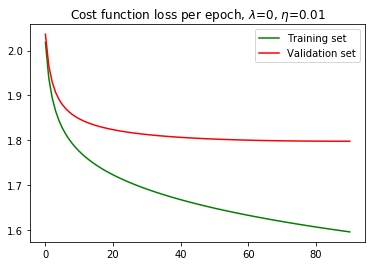

<Figure size 432x288 with 0 Axes>

In [179]:
visualize_costs(cost=training_cost_early_stopping, 
                eta=0.01, regularization_term=0, val_cost=validation_cost_early_stopping,vis=True)

In [174]:
acc_early_stopping= ComputeAccuracy(X=X_test, y=y_test, W=W_early_stopping, b=b_early_stopping)

The accuracy derived when using early stopping is approximately 38.04%:

In [175]:
acc_early_stopping

0.38039999999999996

Visualizing the weights learned from the usage of early stopping:

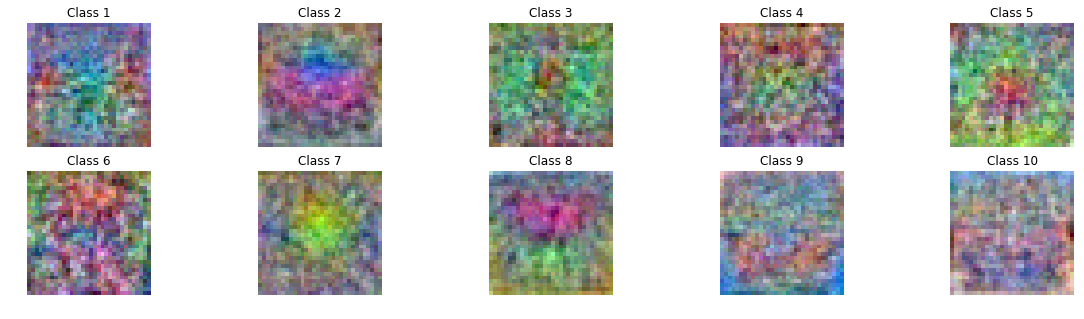

<Figure size 432x288 with 0 Axes>

In [180]:
weights_vis(W=W_early_stopping, GDparams=[100,0.01,100], regularization_term=0, vis=True)

#### Improvement no.2: Using all the available datasets for training, and keeping only the last 1000 data from the second training batch (original training set) as the new validation set

Prepare the whole dataset

In [184]:
    X_training_3, Y_training_3, y_training_3 = LoadBatch('../../cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch('../../cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch('../../cifar-10-batches-py/data_batch_5')
    
    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))
    
    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))
    
    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)
    
    y_training= y_training_1 + y_training_3+ y_training_4+ y_training_5+ y_training_2[:9000]
    
    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]


Train in the whole dataset except for a small batch (~1000 data) used for validation set

In [185]:
weight_full_dataset, bias_full_dataset = initialize_weights(d= 3072, K= 10, variance= 0.01, mode="normal")

In [186]:
    W_full_dataset, b_full_dataset, training_cost_full_dataset, validation_cost_full_dataset = MiniBatchGD(
        X=X_training,
        Y=Y_training,
        validation_X= X_validation,
        validation_Y= Y_validation,
        y=y_training,
        y_validation=y_validation,
        GDparams=[100,0.01,40],
        W=weight_full_dataset,
        b=bias_full_dataset,
        regularization_term=0,
        loss_mode="cross-entropy",
        with_early_stopping=False,
        with_patience=False)

The evolution of cost when all the data except a small fraction (1000 in particular) is given by the following plot:

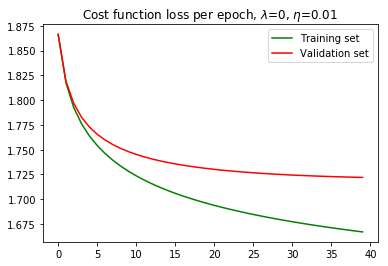

<Figure size 432x288 with 0 Axes>

In [187]:
visualize_costs(cost=training_cost_full_dataset, 
                eta=0.01, regularization_term=0, val_cost=validation_cost_full_dataset,vis=True)

In [188]:
acc_full_dataset= ComputeAccuracy(X=X_test, y=y_test, W=W_full_dataset, b=b_full_dataset)

The accuracy when training on the full dataset is approximately 41%:

In [189]:
acc_full_dataset

0.40990000000000004

The weights learned from using all the available data in the training set:

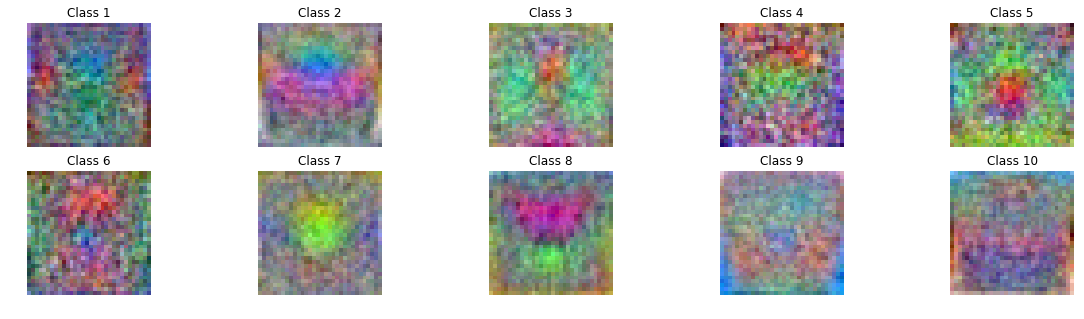

<Figure size 432x288 with 0 Axes>

In [190]:
weights_vis(W=W_full_dataset, GDparams=[100,0.01,40], regularization_term=0, vis=True)

#### Improvement no.3: Training 5 different classifiers (one from each dataset) and predicting the class of each data using the majority vote. 
During the "voting" process, each classifier is rated according to its votes up to this point. When 2 or more classes share equal votes, the best classifier so far decides for the predicted class index.

In [191]:
    classifiers = []


Training on the first dataset

In [192]:
weight_matrix_1, bias_1 = initialize_weights(d=3072, K=10,variance=0.01, mode="normal")

W1, b1, _, _ = MiniBatchGD(
    X=X_training_1,
    Y=Y_training_1,
    validation_X=X_validation,
    validation_Y=Y_validation,
    y=y_training_1,
    y_validation=y_validation,
    GDparams=[100, 0.01, 40],
    W=weight_matrix_1,
    b=bias_1,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False)

classifiers.append(EvaluateClassifier(X_test,W1,b1))

Training on the second dataset

In [193]:
weight_matrix_2, bias_2 = initialize_weights(d=3072, K=10,variance=0.01, mode="normal")

W2, b2,  _, _ = MiniBatchGD(
    X=X_training_2[:9000],
    Y=Y_training_2[:9000],
    validation_X=X_validation,
    validation_Y=Y_validation,
    y=y_training_2,
    y_validation=y_validation,
    GDparams=[100, 0.01, 40],
    W=weight_matrix_2,
    b=bias_2,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False)

classifiers.append(EvaluateClassifier(X_test,W2,b2))

Training on the third dataset

In [194]:
weight_matrix_3, bias_3 = initialize_weights(d=3072, K=10,variance=0.01, mode="normal")

W3, b3,  _, _ = MiniBatchGD(
    X=X_training_3,
    Y=Y_training_3,
    validation_X=X_validation,
    validation_Y=Y_validation,
    y=y_training_3,
    y_validation=y_validation,
    GDparams=[100, 0.01, 40],
    W=weight_matrix_3,
    b=bias_3,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False)

classifiers.append(EvaluateClassifier(X_test,W3,b3))

Training on the fourth dataset

In [195]:
weight_matrix_4, bias_4 = initialize_weights(d=3072, K=10,variance=0.01, mode="normal")

W4, b4,  _, _ = MiniBatchGD(
    X=X_training_4,
    Y=Y_training_4,
    validation_X=X_validation,
    validation_Y=Y_validation,
    y=y_training_4,
    y_validation=y_validation,
    GDparams=[100, 0.01, 40],
    W=weight_matrix_4,
    b=bias_4,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False)

classifiers.append(EvaluateClassifier(X_test,W4,b4))

Training on the fifth dataset

In [196]:
weight_matrix_5, bias_5 = initialize_weights(d=3072, K=10,variance=0.01, mode="normal")

W5, b5,  _, _ = MiniBatchGD(
    X=X_training_5,
    Y=Y_training_5,
    validation_X=X_validation,
    validation_Y=Y_validation,
    y=y_training_5,
    y_validation=y_validation,
    GDparams=[100, 0.01, 40],
    W=weight_matrix_5,
    b=bias_5,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False)

classifiers.append(EvaluateClassifier(X_test,W5,b5))

In [198]:
accuracy_ensembling= ComputeAccuracyEnsemble(X_test, y_test, classifiers)

The accuracy of the ensembling method is 39.48%

In [199]:
accuracy_ensembling

0.39480000000000004

#### Improvement no.4: Running a fine_tuning algorithm to define proper values for $\eta$ and $\lambda$

We run experiments in a relatively broad space of values for $\eta$ and $\lambda$ in order to define a good pair of values for these two hyperparameters

In [104]:
weight_matrix_fine_tuning_1, bias_fine_tuning_1 = initialize_weights(d=3072, K=10, variance=0.01, mode="normal")
best_acc = 0

for eta in np.arange(0.001,0.015,0.001):

    for reg in [0, 0.0001, 0.001, 0.01, 0.1]:
        W_temp, b_temp, _, _ = MiniBatchGD(
            X=X_training_1,
            Y=Y_training_1,
            validation_X=X_training_2,
            validation_Y=Y_training_2,
            y=y_training_1,
            y_validation=y_training_2,
            GDparams=[100, eta, 40],
            W=weight_matrix_fine_tuning_1,
            b=bias_fine_tuning_1,
            regularization_term=reg,
            loss_mode="cross-entropy",
            with_early_stopping=False,
            with_patience=False)

        acc = ComputeAccuracy(X_test, y_test, W_temp, b_temp)
        print_string= "Lambda: "+str(reg)+", eta: "+str(eta)+", accuracy:"+str(acc)
        if acc > best_acc:
            print(print_string+", BEST SO FAR")
            best_acc = acc
        else:
            print(print_string)

Lambda: 0, eta: 0.001, accuracy:0.3597, BEST SO FAR
Lambda: 0.0001, eta: 0.001, accuracy:0.3714, BEST SO FAR
Lambda: 0.001, eta: 0.001, accuracy:0.3786, BEST SO FAR
Lambda: 0.01, eta: 0.001, accuracy:0.3819, BEST SO FAR
Lambda: 0.1, eta: 0.001, accuracy:0.3781
Lambda: 0, eta: 0.002, accuracy:0.3827, BEST SO FAR
Lambda: 0.0001, eta: 0.002, accuracy:0.3852, BEST SO FAR
Lambda: 0.001, eta: 0.002, accuracy:0.3879, BEST SO FAR
Lambda: 0.01, eta: 0.002, accuracy:0.389, BEST SO FAR
Lambda: 0.1, eta: 0.002, accuracy:0.3776
Lambda: 0, eta: 0.003, accuracy:0.3825
Lambda: 0.0001, eta: 0.003, accuracy:0.3878
Lambda: 0.001, eta: 0.003, accuracy:0.3898, BEST SO FAR
Lambda: 0.01, eta: 0.003, accuracy:0.3909, BEST SO FAR
Lambda: 0.1, eta: 0.003, accuracy:0.369
Lambda: 0, eta: 0.004, accuracy:0.3847
Lambda: 0.0001, eta: 0.004, accuracy:0.3886
Lambda: 0.001, eta: 0.004, accuracy:0.3895
Lambda: 0.01, eta: 0.004, accuracy:0.3917, BEST SO FAR
Lambda: 0.1, eta: 0.004, accuracy:0.3652
Lambda: 0, eta: 0.005, 

#### The best accuracy derived for $\eta$ and $\lambda$ was 39.17% for ($\eta$, $\lambda$)= (0.004, 0.01)  

#### Improvement no.5: Decay the learning rate by a factor of 0.9 after each epoch, staring value of $\eta$ is 0.1 

In [200]:
weight_factor_decaying, bias_factor_decaying = initialize_weights(d= 3072, K= 10, variance= 0.01, mode="normal")

W_factor_decaying, b_factor_decaying, training_factor_decaying, validation_factor_decaying = MiniBatchGD(
    X=X_training_1,
    Y=Y_training_1,
    validation_X= X_training_2,
    validation_Y= Y_training_2,
    y=y_training_1,
    y_validation=y_training_2,
    GDparams=[100,0.01,40], #0.01 fir eta is not used at all in this case
    W=weight_factor_decaying,
    b=bias_factor_decaying,
    regularization_term=0,
    loss_mode="cross-entropy",
    with_early_stopping=False,
    with_patience=False,
    with_factor_decaying=True)

The training and validation cost evolution when decaying $\eta$ after each epoch are plotted in the following graph

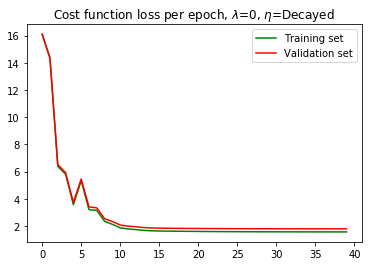

<Figure size 432x288 with 0 Axes>

In [201]:
visualize_costs(cost=training_factor_decaying, val_cost=validation_factor_decaying, regularization_term=0, eta='Decayed', vis=True)

The weights learned from this procedure are:

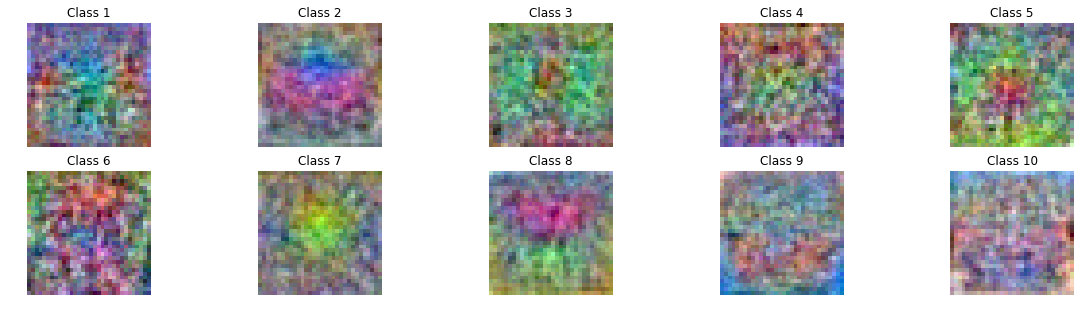

<Figure size 432x288 with 0 Axes>

In [219]:
weights_vis(W=W_factor_decaying, GDparams=[[100,'Decayed',40]], regularization_term=0, vis=True, name="w_factor_dec")

In [203]:
accuracy_factor_decaying= ComputeAccuracy(X=X_test, y=y_test, W=W_factor_decaying, b=b_factor_decaying) 

The accuracy of this method is 38.57%

In [204]:
accuracy_factor_decaying

0.38570000000000004

## Exercise 2.2: Train and compute gradients based on the SVM loss

### SVM Loss
#### Implementing the loss function for multi-class SVM classifier
Refer to http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture3.pdf for the formulas

In [111]:
def ComputeLossSVM(X, y, X_validation, y_validation, W, regularization_term):
    
    svm_loss=0    
    val_svm_loss=0
    
    for i in range(X.shape[1]):
        
        scores = np.dot(W,X[:,i])       
        true_score = scores[y[i]]
        
        val_scores = np.dot(W,X_validation[:,i])       
        val_true_score = scores[y_validation[i]]
        
        for j in range(W.shape[0]):
            if j == y[i]:
                continue
            margin = scores[j] - true_score + 1
            val_margin = val_scores[j] - val_true_score + 1
            
            if margin>0:
                svm_loss+= margin
            if val_margin>0:
                val_svm_loss+= val_margin
                
    
    svm_loss/=X.shape[1]
    val_svm_loss/=X.shape[1]

    return svm_loss, val_svm_loss

### Compute gradients  when using SVM loss
Refer to https://stats.stackexchange.com/questions/155088/gradient-for-hinge-loss-multiclass?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa for the formulas

In [112]:
def ComputeGradientsSVM(X, y, W, regularization_term):

    grad_W = np.zeros(W.shape) 

    for i in range(X.shape[1]):

        scores = np.dot(W,X[:,i])
        true_score = scores[y[i]]

        for j in range(W.shape[0]):
            if j == y[i]:
                continue
            margin = scores[j] - true_score + 1
            if margin > 0:
                grad_W[y[i],:] -= X[:,i]
                grad_W[j,: ] += X[:,i]
                
    grad_W /= float(X.shape[1])
    weight_sum = np.power(W, 2).sum()

    return  grad_W + regularization_term*W

### Compute the accuracy of SVM training

In [131]:
def ComputeAccuracySVM(W, X, y):
    
    scores= np.dot(W,X)
    predictions= np.argmax(scores, axis=0)
    
    error= np.count_nonzero(predictions-y)/float(X.shape[1])
    
    return 1-error

For the computing calculations due to SVM loss, we applly the bias trick in the weight matrix: 

1) Last column of W is filled with the bias matrix values

2) Last row of the X matrix is filled with ones

In [139]:
weight_svm_temp, bias_svm = initialize_weights(d= 3072, K= 10, variance= 0.01, mode="normal")

In [140]:
Weight_svm= np.copy( np.concatenate((weight_svm_temp,bias_svm), axis=1) )
X_training_1_extended= np.concatenate( (X_training_1,np.ones((1, X_training_1.shape[1]))), axis=0) 
X_training_2_extended= np.concatenate( (X_training_2,np.ones((1, X_training_2.shape[1]))), axis=0) 
X_test_extended= np.concatenate( (X_test,np.ones((1, X_training_2.shape[1]))), axis=0) 

#### Re-define MiniBatchGD function in order to compute gradients based on SVM loss  

In [134]:
def MiniBatchGDSVM( X, y, validation_X, y_validation, GDparams, W, regularization_term):

    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches=GDparams[2]

    cost=[]
    val_cost=[]


    for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):

            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            gradW= ComputeGradientsSVM(X=X[:, start:end],y=y[start:end], W=W, regularization_term=regularization_term)

            W -= eta * gradW
        
        training_loss, validation_loss = ComputeLossSVM(X=X, y=y, X_validation=validation_X, y_validation=y_validation, W=W, regularization_term=regularization_term)

        cost.append(training_loss)
        val_cost.append(validation_loss)

    return W, cost, val_cost

#### Experiments and results

In [135]:
W1_svm, training_loss_1_svm, validation_loss_1_svm= MiniBatchGDSVM(
                                        X=X_training_1_extended, 
                                        y=y_training_1, 
                                        validation_X=X_training_2_extended, 
                                        y_validation=y_training_2, 
                                        GDparams=[100, 0.01, 40], 
                                        W=Weight_svm, 
                                        regularization_term=0)

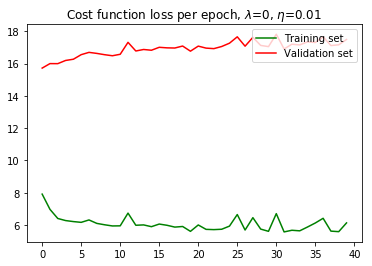

<Figure size 432x288 with 0 Axes>

In [207]:
visualize_costs(cost=training_loss_1_svm, val_cost=validation_loss_1_svm, eta=0.01, regularization_term=0,vis=True, name="svm_1")

The following plot visualizes the weights learned:

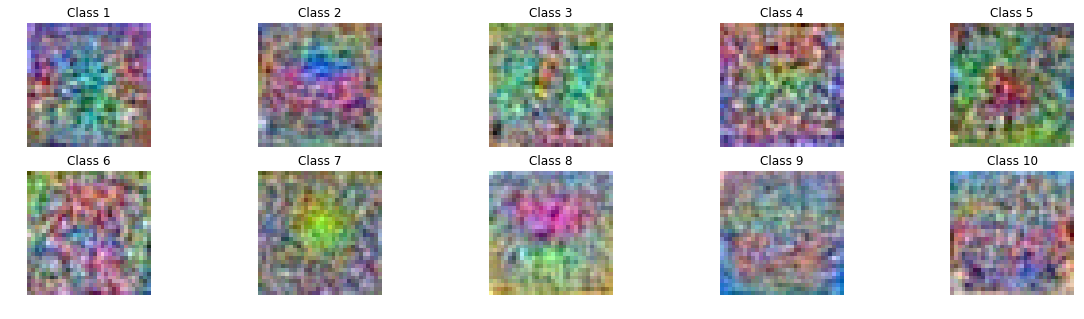

<Figure size 432x288 with 0 Axes>

In [216]:
weights_vis(GDparams=[100,0.01,40], regularization_term=0, W=W1_svm[:,:-1], vis=True)

In [137]:
acc= ComputeAccuracySVM(W=W1_svm, X=X_test_extended, y=y_test)

The estimated accuracy for this setting is 29.56%

In [138]:
acc

0.2956

We run one more experiment, with a smaller learnig step (0.001) and  little regularization (0.01)

In [141]:
W2_svm, training_loss_2_svm, validation_loss_2_svm= MiniBatchGDSVM(
                                        X=X_training_1_extended, 
                                        y=y_training_1, 
                                        validation_X=X_training_2_extended, 
                                        y_validation=y_training_2, 
                                        GDparams=[100, 0.001, 40], 
                                        W=Weight_svm, 
                                        regularization_term=0)

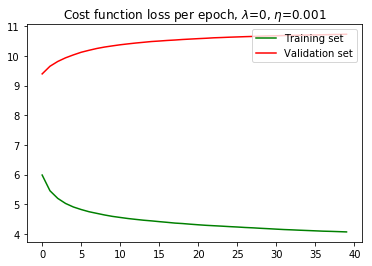

<Figure size 432x288 with 0 Axes>

In [213]:
visualize_costs(cost=training_loss_2_svm, val_cost=validation_loss_2_svm, eta=0.001, regularization_term=0,vis=True, name="svm_2")

In [143]:
acc= ComputeAccuracySVM(W=W2_svm, X=X_test_extended, y=y_test)

The following plot visualizes the weights learned:

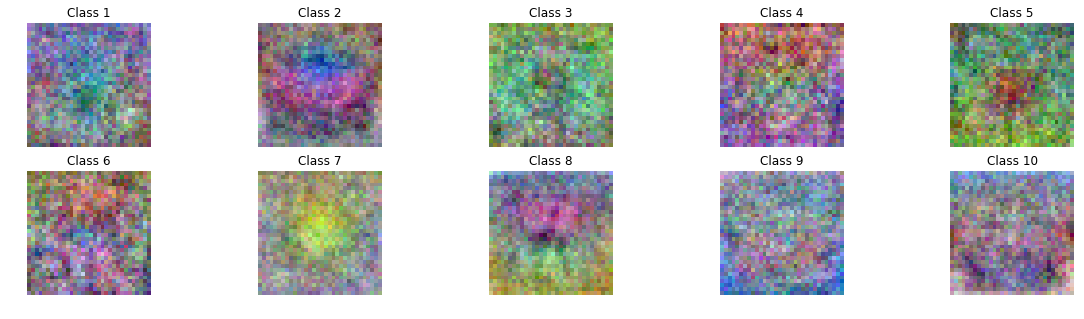

<Figure size 432x288 with 0 Axes>

In [217]:
weights_vis(GDparams=[100,0.001,40], regularization_term=0.01, W=W2_svm[:,:-1], vis=True)

The training loss has anti-symmetric behavior in comparison with the validation loss

The estimated accuracy is 36.17%

In [145]:
acc

0.3617

### To recapitulate, and comparing SVM loss with the Croos-Entropy loss, the latter has more stable behavior and better performance in terms of accuracy